In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

Lung12_generate.ipynb	   Lung5_Rep2_generate.ipynb  Lung9_Rep1_generate.ipynb
Lung13_generate.ipynb	   Lung5_Rep3_generate.ipynb  Lung9_Rep2_generate.ipynb
Lung5_Rep1_generate.ipynb  Lung6_generate.ipynb       notes.txt
/mnt/ufs18/home-144/dingjia5/projects/CosMx_lung/benchmark_generation_scripts


### standard: fov in metadata_file, not Run1080_SP19_1139_fov_positions_file


# Transcript Data

In [4]:
import pandas as pd


In [5]:
gene_spatial = pd.read_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/Lung9_Rep2_tx_file.csv')
gene_spatial

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
0,1,0,-15185.000000,-27050.802778,3765.000000,1826.975000,7,IL1RL1,0
1,1,0,-15715.033400,-26492.922278,3234.966600,2384.855500,7,EPHA4,0
2,1,0,-13789.850000,-26833.627778,5160.150000,2044.150000,7,OLR1,0
3,1,0,-16333.900000,-28575.737978,2616.100000,302.039800,7,NRG4,0
4,1,0,-16737.175000,-28345.502778,2212.825000,532.275000,7,DCN,0
...,...,...,...,...,...,...,...,...,...
33443053,45,3044,7786.529026,334.102349,4847.640137,11.880127,3,HLA-B,Cytoplasm
33443054,45,3044,7790.868869,335.822320,4851.979980,13.600098,3,FCGR3A,Cytoplasm
33443055,45,3044,7774.738987,334.797173,4835.850098,12.574951,2,PTGIS,Cytoplasm
33443056,45,3044,7783.644748,333.044488,4844.755859,10.822266,7,NOSIP,Cytoplasm


In [6]:
gene_spatial.shape

(33443058, 9)

In [7]:
min(gene_spatial["x_global_px"]), max(gene_spatial["x_global_px"])

(-18940.6999998093, 8400.23898654514)

In [8]:
min(gene_spatial["y_global_px"]), max(gene_spatial["y_global_px"])

(-28867.377875434, 3960.47222222222)

In [9]:
min(gene_spatial["x_local_px"]), max(gene_spatial["x_local_px"])

(9.27499961853027, 5461.60009765625)

In [10]:
min(gene_spatial["y_local_px"]), max(gene_spatial["y_local_px"])

(10.22509765625, 3638.5)

In [11]:
gene_spatial.loc[gene_spatial['fov']==9].shape

(1099948, 9)

In [12]:
gene_spatial.loc[gene_spatial['fov']==9].shape

(1099948, 9)

In [13]:
filtered_data_fov1_cell_ID_1 =  gene_spatial[(gene_spatial['fov']==9) & (gene_spatial['cell_ID']==1)]
filtered_data_fov1_cell_ID_1

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
7136574,9,1,-1145.087233,-21618.931625,1388.246100,3608.846153,7,IGFBP5,Cytoplasm
7136575,9,1,-1179.419133,-21654.877778,1353.914200,3572.900000,7,HSPA1B,Membrane
7136576,9,1,-1197.895833,-21622.046528,1335.437500,3605.731250,7,COL6A2,Nuclear
7136577,9,1,-1206.425633,-21611.808548,1326.907700,3615.969230,7,PTGS1,Membrane
7136578,9,1,-1173.347633,-21617.363494,1359.985700,3610.414284,7,HDAC1,Nuclear
...,...,...,...,...,...,...,...,...,...
7136914,9,1,-1193.700033,-21649.427779,1339.633301,3578.349998,4,TNFRSF12A,Membrane
7136915,9,1,-1178.983358,-21622.777778,1354.349976,3605.000000,4,MECOM,Nuclear
7136916,9,1,-1189.973348,-21608.037778,1343.359985,3619.740000,4,IGFBP5,Nuclear
7136917,9,1,-1168.466756,-21610.344443,1364.866577,3617.433334,4,KRT15,Membrane


In [14]:
gene_expression = pd.read_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/Lung9_Rep2_exprMat_file.csv')
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,39,84,86,53,80,49,73,62,...,46,42,39,60,34,48,59,40,49,64
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150544,45,3040,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150545,45,3041,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150546,45,3042,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150547,45,3043,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
gene_expression.shape

(150549, 982)

In [16]:
cell_boundary = pd.read_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/Lung9_Rep2_metadata_file.csv')
cell_boundary


,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1066,2.26,714,3635,-18236.000000,-25242.777778,61,27,29541,51989,131,512,976,6094,53,1231,5259,8931
1,1,2,3159,1.21,753,3619,-18197.000000,-25258.777778,70,58,29541,57428,66,1244,2176,11296,12,1046,2159,9635
2,1,3,1570,1.43,1453,3631,-17497.000000,-25246.777778,50,35,8884,23037,210,692,16,699,15,649,2856,8497
3,1,4,4527,1.67,1527,3618,-17423.000000,-25259.777778,100,60,10998,23948,964,7505,93,9696,15,1034,1737,12129
4,1,5,3659,1.63,2660,3619,-16290.000000,-25258.777778,96,59,26360,51352,1332,9568,179,1331,43,1886,2314,11227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150499,45,3040,1854,2.39,1336,17,4274.888889,339.222222,74,31,14434,31918,611,2295,229,8556,4,306,773,1905
150500,45,3041,775,1.87,1387,13,4325.888889,335.222222,43,23,17157,31514,555,2185,0,138,0,23,1388,2701
150501,45,3042,1629,3.42,268,13,3206.888889,335.222222,82,24,33971,63567,18165,39887,14,807,0,0,608,1859
150502,45,3043,545,3.40,3542,9,6480.888889,331.222222,51,15,29605,41251,8258,15429,66,1250,0,0,512,1091


In [17]:
min(cell_boundary["CenterX_global_px"]), max(cell_boundary["CenterX_global_px"])

(-18939.0, 8401.88888888889)

In [18]:
min(cell_boundary["CenterY_global_px"]), max(cell_boundary["CenterY_global_px"])

(-28868.7777777778, 3963.22222222222)

In [19]:
cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==9)]
cell_boundary_fov_1

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
27242,9,1,4080,1.18,1352,3597,-1181.333333,-21630.777778,79,67,42260,63743,3034,8447,7,3349,0,0,640,5852
27243,9,2,4664,1.42,1515,3596,-1018.333333,-21631.777778,98,69,42576,63583,6783,27198,3,580,0,0,284,4935
27244,9,3,1990,1.29,1832,3608,-701.333333,-21619.777778,58,45,20413,39602,3807,12640,0,2,0,0,1738,5548
27245,9,4,2653,0.72,1993,3592,-540.333333,-21635.777778,55,76,24453,53621,4321,14952,0,0,0,0,1884,6241
27246,9,5,2959,1.84,2058,3609,-475.333333,-21618.777778,79,43,20290,53844,4297,18198,0,2,0,0,1332,5212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31487,9,4246,1266,3.48,1600,12,-933.333333,-25215.777778,73,21,17497,39919,8822,26240,2,93,0,0,2801,4811
31488,9,4247,1511,2.23,2438,16,-95.333333,-25211.777778,67,30,11517,18688,7098,17603,0,71,0,0,2508,4563
31489,9,4248,1541,1.97,3616,17,1082.666667,-25210.777778,61,31,30485,53285,4138,9927,0,96,0,0,1728,6067
31490,9,4249,2159,3.26,3880,15,1346.666667,-25212.777778,88,27,24708,64127,4794,10640,2,135,0,0,2085,8192


In [20]:
type(cell_boundary_fov_1)
# cell_boundary_fov_1.to_csv('sample_fov2.csv')

pandas.core.frame.DataFrame

In [21]:
cell_boundary_fov_1.iloc[0]["CenterX_local_px"]

1352.0

In [22]:
cell_boundary_fov_1.iloc[0]["CenterY_local_px"]

3597.0

In [23]:
min(cell_boundary_fov_1["CenterX_local_px"]), max(cell_boundary_fov_1["CenterX_local_px"])

(10, 5449)

In [24]:
min(cell_boundary_fov_1["CenterY_local_px"]), max(cell_boundary_fov_1["CenterY_local_px"])

(12, 3617)

In [25]:
fov_position = pd.read_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/Lung9_Rep2_fov_positions_file.csv')

# fov_position = pd.read_csv('../Run1080_SP20_10838/Run1080_SP20_10838_fov_positions_file.csv')
fov_position

,fov,x_global_px,y_global_px
0,1,-18950.000000,-28877.777778
1,2,-13477.777778,-28877.777778
2,3,-8005.555556,-28877.777778
3,4,-2533.333333,-28877.777778
4,5,2938.888889,-28877.777778
5,6,-18950.000000,-25227.777778
6,7,-13477.777778,-25227.777778
7,8,-8005.555556,-25227.777778
8,9,-2533.333333,-25227.777778
9,10,2938.888889,-25227.777778


In [26]:
x_coordinate = [x / 10000 for x in list(fov_position["x_global_px"])]
x_coordinate

[-1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903,
 -1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903,
 -1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903,
 -1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903,
 -1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903,
 -1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903,
 -1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903,
 -1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903,
 -1.895,
 -1.34777777777778,
 -0.800555555555556,
 -0.25333333333333297,
 0.29388888888888903]

In [27]:
y_coordinate = [y / 10000 for y in list(fov_position["y_global_px"])]
y_coordinate

[-2.8877777777777798,
 -2.8877777777777798,
 -2.8877777777777798,
 -2.8877777777777798,
 -2.8877777777777798,
 -2.52277777777778,
 -2.52277777777778,
 -2.52277777777778,
 -2.52277777777778,
 -2.52277777777778,
 -2.15777777777778,
 -2.15777777777778,
 -2.15777777777778,
 -2.15777777777778,
 -2.15777777777778,
 -1.79277777777778,
 -1.79277777777778,
 -1.79277777777778,
 -1.79277777777778,
 -1.79277777777778,
 -1.4277777777777798,
 -1.4277777777777798,
 -1.4277777777777798,
 -1.4277777777777798,
 -1.4277777777777798,
 -1.0627777777777798,
 -1.0627777777777798,
 -1.0627777777777798,
 -1.0627777777777798,
 -1.0627777777777798,
 -0.697777777777778,
 -0.697777777777778,
 -0.697777777777778,
 -0.697777777777778,
 -0.697777777777778,
 -0.332777777777778,
 -0.332777777777778,
 -0.332777777777778,
 -0.332777777777778,
 -0.332777777777778,
 0.0322222222222222,
 0.0322222222222222,
 0.0322222222222222,
 0.0322222222222222,
 0.0322222222222222]

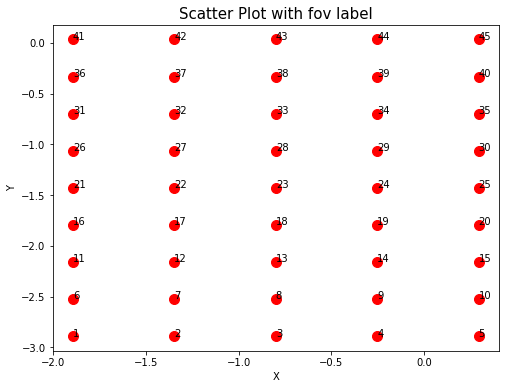

In [28]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

X=np.random.randint(10, size=(5))
Y=np.random.randint(10, size=(5))

X = x_coordinate
Y = y_coordinate

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = list(fov_position["fov"])

plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

In [29]:

fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates                                               

,fov,spot_id,x,y


In [30]:


def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    spot_id = 1
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 4
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 5
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 7
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   # -----------
    spot_id = 9
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 10
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 11
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 12
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # -----------
    spot_id = 13
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 14
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 15
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 16
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # -----------
    spot_id = 17
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 18
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 19
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 20
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
    
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y']
    
    return fov_spot_coordinates
    

In [31]:
coordinates = get_spot_x_y_range(-25727.777778, -164066.666667, 8, fov_spot_coordinates)
coordinates

/tmp/ipykernel_3796/4274499263.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_3796/4274499263.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_3796/4274499263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_3796/4274499263.py:27: FutureWarning: The frame.append method is deprecated and will be rem

,fov,spot_id,x,y
0,8.0,1.0,-25180.577778,-160874.666667
1,8.0,2.0,-25180.577778,-161786.666667
2,8.0,3.0,-25180.577778,-162698.666667
3,8.0,4.0,-25180.577778,-163610.666667
4,8.0,5.0,-24086.177778,-160874.666667
5,8.0,6.0,-24086.177778,-161786.666667
6,8.0,7.0,-24086.177778,-162698.666667
7,8.0,8.0,-24086.177778,-163610.666667
8,8.0,9.0,-22991.777778,-160874.666667
9,8.0,10.0,-22991.777778,-161786.666667


# Benchmark Generation

In [33]:
"""
1 μm(micrometer) = 1e-4 cm
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

'\nGeoMx: spot region area\n1. mean: 37456.28 μm2\n2. median: 24168.74 μm2\n'

In [34]:
"""
CosMx lung: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 
"""

'\nCosMx lung: \n1. All FOVs are the same dimension, 5472 x 3648 pixels\n2. multiply the pixel value by 0.18 um per pixel\n3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 \n'

In [35]:
"""
New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV
"""

'\nNew Benchamrk from CosMx\n1. length: 5472 pixels, width: 3648 pixels\n2. simulated spot: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n    one spot area: 196.992 um * 164.16 um = 32338.2067 um2\n3. In total: 20 spots / FOV\n'

In [36]:
"""
CosMx Kidey dataset:
Assume FOV size on kidney is 5472 x 3648 pixels.

so the pseudo spot still be: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um

"""

'\nCosMx Kidey dataset:\nAssume FOV size on kidney is 5472 x 3648 pixels.\n\nso the pseudo spot still be: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n\n'

In [37]:
"""
spot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)

spot_gene_expression.csv (spot_id, gene1, gene2, gene3...)
"""

'\nspot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)\n\nspot_gene_expression.csv (spot_id, gene1, gene2, gene3...)\n'

## 1. spot_fov_cellId_mapping.csv

In [32]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 1
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 2
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 3
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 4

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 5
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 6
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 7
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 8

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 9
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 10
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 11
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 12

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 13
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 14
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 15
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 16

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 17
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 18
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 19
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 20
        else:
            print("Wrong CenterX_local_px")
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)

    return data_result

        

In [33]:
data_final_result = pd.DataFrame(columns = [ 'fov', 'spot_id', 'cell_ID'])
data_final_result

,fov,spot_id,cell_ID


In [34]:
cell_boundary

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1066,2.26,714,3635,-18236.000000,-25242.777778,61,27,29541,51989,131,512,976,6094,53,1231,5259,8931
1,1,2,3159,1.21,753,3619,-18197.000000,-25258.777778,70,58,29541,57428,66,1244,2176,11296,12,1046,2159,9635
2,1,3,1570,1.43,1453,3631,-17497.000000,-25246.777778,50,35,8884,23037,210,692,16,699,15,649,2856,8497
3,1,4,4527,1.67,1527,3618,-17423.000000,-25259.777778,100,60,10998,23948,964,7505,93,9696,15,1034,1737,12129
4,1,5,3659,1.63,2660,3619,-16290.000000,-25258.777778,96,59,26360,51352,1332,9568,179,1331,43,1886,2314,11227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150499,45,3040,1854,2.39,1336,17,4274.888889,339.222222,74,31,14434,31918,611,2295,229,8556,4,306,773,1905
150500,45,3041,775,1.87,1387,13,4325.888889,335.222222,43,23,17157,31514,555,2185,0,138,0,23,1388,2701
150501,45,3042,1629,3.42,268,13,3206.888889,335.222222,82,24,33971,63567,18165,39887,14,807,0,0,608,1859
150502,45,3043,545,3.40,3542,9,6480.888889,331.222222,51,15,29605,41251,8258,15429,66,1250,0,0,512,1091


In [35]:
type(cell_boundary)

pandas.core.frame.DataFrame

In [36]:
fov_ids_lst = cell_boundary['fov'].unique()
fov_ids_lst

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [37]:
for fov_id in fov_ids_lst:
    print("fov_id:", fov_id, cell_boundary[(cell_boundary['fov']==fov_id)].shape)

fov_id: 1 (3543, 20)
fov_id: 2 (3703, 20)
fov_id: 3 (4123, 20)
fov_id: 4 (3221, 20)
fov_id: 5 (3579, 20)
fov_id: 6 (2356, 20)
fov_id: 7 (2865, 20)
fov_id: 8 (3852, 20)
fov_id: 9 (4250, 20)
fov_id: 10 (3617, 20)
fov_id: 11 (3323, 20)
fov_id: 12 (2415, 20)
fov_id: 13 (3188, 20)
fov_id: 14 (3826, 20)
fov_id: 15 (3333, 20)
fov_id: 16 (3144, 20)
fov_id: 17 (3534, 20)
fov_id: 18 (2678, 20)
fov_id: 19 (3825, 20)
fov_id: 20 (3939, 20)
fov_id: 21 (3306, 20)
fov_id: 22 (3986, 20)
fov_id: 23 (1969, 20)
fov_id: 24 (2348, 20)
fov_id: 25 (2897, 20)
fov_id: 26 (2786, 20)
fov_id: 27 (3435, 20)
fov_id: 28 (2711, 20)
fov_id: 29 (2180, 20)
fov_id: 30 (2528, 20)
fov_id: 31 (3562, 20)
fov_id: 32 (3660, 20)
fov_id: 33 (3452, 20)
fov_id: 34 (2988, 20)
fov_id: 35 (3412, 20)
fov_id: 36 (3535, 20)
fov_id: 37 (3525, 20)
fov_id: 38 (3752, 20)
fov_id: 39 (3501, 20)
fov_id: 40 (3323, 20)
fov_id: 41 (4942, 20)
fov_id: 42 (4063, 20)
fov_id: 43 (3771, 20)
fov_id: 44 (3514, 20)
fov_id: 45 (3044, 20)


In [38]:
cell_boundary[(cell_boundary['fov']==14)]["CenterX_global_px"].tolist()

[-2014.33333333333,
 -1937.33333333333,
 -1895.33333333333,
 -1327.33333333333,
 -1037.33333333333,
 -550.333333333334,
 54.6666666666665,
 2137.66666666667,
 2280.66666666667,
 2780.66666666667,
 637.666666666666,
 706.666666666666,
 2492.66666666667,
 -2227.33333333333,
 -2188.33333333333,
 522.666666666666,
 2435.66666666667,
 1852.66666666667,
 2509.66666666667,
 1201.66666666667,
 2861.66666666667,
 -1056.33333333333,
 -1763.33333333333,
 -341.333333333333,
 2401.66666666667,
 1284.66666666667,
 613.666666666666,
 -132.333333333333,
 2894.66666666667,
 -1811.33333333333,
 95.6666666666664,
 2550.66666666667,
 -2124.33333333333,
 2454.66666666667,
 -1695.33333333333,
 2320.66666666667,
 162.666666666667,
 2771.66666666667,
 2847.66666666667,
 -2270.33333333333,
 1959.66666666667,
 1367.66666666667,
 -1335.33333333333,
 -1637.33333333333,
 2568.66666666667,
 -1383.33333333333,
 -166.333333333333,
 97.6666666666666,
 -1815.33333333333,
 1833.66666666667,
 2486.66666666667,
 2909.6666

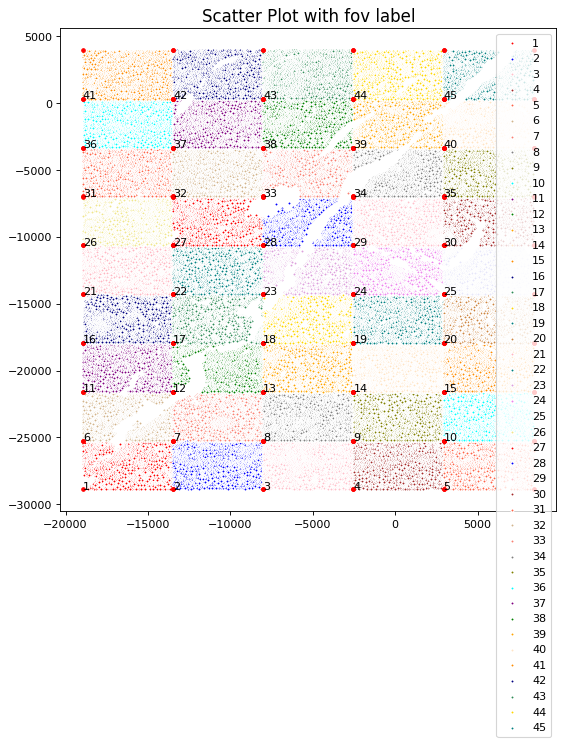

In [39]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

plt.scatter(X,Y,s=10,color="red")
plt.scatter(X_plus, Y_plus,s=10,color="red")
plt.scatter(X_plus, Y,s=10,color="red")
plt.scatter(X, Y_plus,s=10,color="red")


plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))


plt.show()


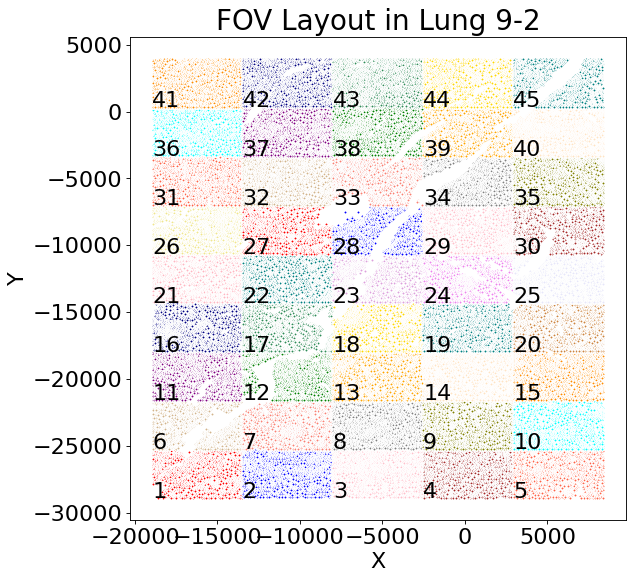

In [40]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
#     plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

# plt.scatter(X,Y,s=10,color="red")
# plt.scatter(X_plus, Y_plus,s=10,color="red")
# plt.scatter(X_plus, Y,s=10,color="red")
# plt.scatter(X, Y_plus,s=10,color="red")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title("FOV Layout in Lung 9-2",fontsize=25)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]), size=20)

plt.savefig("../../FOV_layout/Lung9-2.png", format="png", bbox_inches="tight")
plt.show()


In [43]:
fov_ids_lst = cell_boundary['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_id)]
    print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_fov)

data_final_result

fov_ids_lst: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
fov_id: 1
cell_boundary_fov_without_spot_id: (3543, 20)
fov_id: 2
cell_boundary_fov_without_spot_id: (3703, 20)
fov_id: 3
cell_boundary_fov_without_spot_id: (4123, 20)
fov_id: 4
cell_boundary_fov_without_spot_id: (3221, 20)
fov_id: 5
cell_boundary_fov_without_spot_id: (3579, 20)
fov_id: 6
cell_boundary_fov_without_spot_id: (2356, 20)
fov_id: 7
cell_boundary_fov_without_spot_id: (2865, 20)
fov_id: 8
cell_boundary_fov_without_spot_id: (3852, 20)
fov_id: 9
cell_boundary_fov_without_spot_id: (4250, 20)
fov_id: 10
cell_boundary_fov_without_spot_id: (3617, 20)
fov_id: 11
cell_boundary_fov_without_spot_id: (3323, 20)
fov_id: 12
cell_boundary_fov_without_spot_id: (2415, 20)
fov_id: 13
cell_boundary_fov_without_spot_id: (3188, 20)
fov_id: 14
cell_boundary_fov_without_spot_id: (3826, 20)
fov_id: 15
cell_boundary_fov_without_spot_id: (3333, 20)
fov

,fov,spot_id,cell_ID
0,1.0,4.0,1.0
1,1.0,4.0,2.0
2,1.0,8.0,3.0
3,1.0,8.0,4.0
4,1.0,12.0,5.0
...,...,...,...
150499,45.0,5.0,3040.0
150500,45.0,5.0,3041.0
150501,45.0,1.0,3042.0
150502,45.0,13.0,3043.0


In [44]:
data_final_result

,fov,spot_id,cell_ID
0,1.0,4.0,1.0
1,1.0,4.0,2.0
2,1.0,8.0,3.0
3,1.0,8.0,4.0
4,1.0,12.0,5.0
...,...,...,...
150499,45.0,5.0,3040.0
150500,45.0,5.0,3041.0
150501,45.0,1.0,3042.0
150502,45.0,13.0,3043.0


In [45]:
data_final_result_sample = data_final_result[(data_final_result['fov']==14)]
data_final_result_sample

,fov,spot_id,cell_ID
44035,14.0,4.0,1.0
44036,14.0,4.0,2.0
44037,14.0,4.0,3.0
44038,14.0,8.0,4.0
44039,14.0,8.0,5.0
...,...,...,...
47856,14.0,1.0,3822.0
47857,14.0,17.0,3823.0
47858,14.0,5.0,3824.0
47859,14.0,17.0,3825.0


In [46]:
data_final_result.to_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')

In [47]:
data_final_result

,fov,spot_id,cell_ID
0,1.0,4.0,1.0
1,1.0,4.0,2.0
2,1.0,8.0,3.0
3,1.0,8.0,4.0
4,1.0,12.0,5.0
...,...,...,...
150499,45.0,5.0,3040.0
150500,45.0,5.0,3041.0
150501,45.0,1.0,3042.0
150502,45.0,13.0,3043.0


## 2. spot_gene_expression.csv

In [50]:
data_final_result = pd.read_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
data_final_result

,Unnamed: 0,fov,spot_id,cell_ID
0,0,1.0,4.0,1.0
1,1,1.0,4.0,2.0
2,2,1.0,8.0,3.0
3,3,1.0,8.0,4.0
4,4,1.0,12.0,5.0
...,...,...,...,...
150499,150499,45.0,5.0,3040.0
150500,150500,45.0,5.0,3041.0
150501,150501,45.0,1.0,3042.0
150502,150502,45.0,13.0,3043.0


In [51]:
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,39,84,86,53,80,49,73,62,...,46,42,39,60,34,48,59,40,49,64
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150544,45,3040,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150545,45,3041,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150546,45,3042,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150547,45,3043,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20'])
fov_spot_cells_stats


,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20


In [53]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0,
 'spot-id=10': 0,
 'spot-id=11': 0,
 'spot-id=12': 0,
 'spot-id=13': 0,
 'spot-id=14': 0,
 'spot-id=15': 0,
 'spot-id=16': 0,
 'spot-id=17': 0,
 'spot-id=18': 0,
 'spot-id=19': 0,
 'spot-id=20': 0}

In [54]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)



In [55]:
fov_spot_cells_stats.to_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20
0,1,98,152,157,188,174,195,130,120,147,...,217,182,170,180,200,225,181,210,230,190
1,2,226,169,186,149,160,186,147,172,150,...,181,215,141,222,206,211,112,180,256,275
2,3,149,172,232,233,186,212,290,213,222,...,244,219,209,243,197,188,131,161,184,178
3,4,124,139,197,151,179,165,182,193,161,...,182,209,133,146,159,180,136,121,105,202
4,5,147,136,141,139,202,217,142,190,242,...,216,153,110,143,255,176,198,168,174,222
5,6,171,201,160,125,79,152,127,125,94,...,131,109,142,74,5,114,159,180,72,94
6,7,147,110,123,52,149,160,134,73,223,...,162,146,197,201,155,92,160,152,133,118
7,8,242,171,150,126,190,240,224,139,243,...,222,214,168,201,220,158,191,187,189,174
8,9,211,236,198,206,210,289,327,203,227,...,216,169,206,201,135,181,202,154,191,227
9,10,174,186,184,217,227,165,222,160,232,...,132,157,259,163,137,157,195,140,160,160


In [56]:
data_final_result[(data_final_result['fov']==fov_id)]

,Unnamed: 0,fov,spot_id,cell_ID
147460,147460,45.0,12.0,1.0
147461,147461,45.0,16.0,2.0
147462,147462,45.0,20.0,3.0
147463,147463,45.0,20.0,4.0
147464,147464,45.0,8.0,5.0
...,...,...,...,...
150499,150499,45.0,5.0,3040.0
150500,150500,45.0,5.0,3041.0
150501,150501,45.0,1.0,3042.0
150502,150502,45.0,13.0,3043.0


In [57]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = (gene_expression.columns)[2:].tolist()
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACE',
 'ACE2',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRB2',
 'ADGRB3',
 'ADGRD1',
 'ADGRE1',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF4',
 'ADGRF5',
 'ADGRG1',
 'ADGRG2',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'ADORA2A',
 'AGR2',
 'AHI1',
 'AHR',
 'AKT1',
 'ALCAM',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',
 'ANGPTL1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOB',
 'APOD',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARTN',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BATF3',
 'BAX',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP6',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BMX',
 'BRCA1',
 'BST1',
 'BST2',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA'

In [58]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23


In [59]:
def get_spot_gene_expression(spot_cell_mapping, fov_expression, spot_id):
    genes_lst = (fov_expression.columns)[2:].tolist()
    
#     gene_count_dic = {}
#     for gene_name in genes_lst:
#         gene_count_dic[gene_name] = 0
    
    cell_id_lst = spot_cell_mapping[(spot_cell_mapping['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        cell_gene_expression = cell_gene_expression.values.tolist()[0][2:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()
                
#         for gene_name in genes_lst:
#             gene_count_dic[gene_name] = gene_count_dic[gene_name] + cell_gene_expression[gene_name]
    
    return cell_gene_expression_total
    
    
    
        
    
    

In [60]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    print("fov_id:", fov_id)
#     print("fov_data", fov_data)
    fov_gene_expression = gene_expression[(gene_expression['fov'] == fov_id)]
#     print("fov_gene_expression:", fov_gene_expression)
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_data, fov_gene_expression, spot_id)
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
       
#     print(spot_gene_express, len(spot_gene_express))
    
    
  

fov_id: 1
fov_id: 2
fov_id: 3
fov_id: 4
fov_id: 5
fov_id: 6
fov_id: 7
fov_id: 8
fov_id: 9
fov_id: 10
fov_id: 11
fov_id: 12
fov_id: 13
fov_id: 14
fov_id: 15
fov_id: 16
fov_id: 17
fov_id: 18
fov_id: 19
fov_id: 20
fov_id: 21
fov_id: 22
fov_id: 23
fov_id: 24
fov_id: 25
fov_id: 26
fov_id: 27
fov_id: 28
fov_id: 29
fov_id: 30
fov_id: 31
fov_id: 32
fov_id: 33
fov_id: 34
fov_id: 35
fov_id: 36
fov_id: 37
fov_id: 38
fov_id: 39
fov_id: 40
fov_id: 41
fov_id: 42
fov_id: 43
fov_id: 44
fov_id: 45


In [61]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,1,1,6,3,1,7,2,2,1,...,5,1,1,4,1,3,3,1,5,1
1,1,2,3,5,4,5,10,3,5,2,...,4,3,4,6,3,7,1,4,3,7
2,1,3,6,4,4,0,8,2,9,2,...,2,0,4,3,2,3,3,0,8,6
3,1,4,4,10,9,2,9,1,1,7,...,0,5,1,9,4,2,3,0,8,6
4,1,5,8,10,12,11,14,7,8,6,...,4,3,5,6,7,4,4,10,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,45,16,2,6,6,0,0,2,1,4,...,6,0,3,0,1,0,1,2,4,0
896,45,17,16,32,29,12,18,7,26,11,...,6,3,15,11,11,9,16,7,14,13
897,45,18,6,16,18,9,11,4,12,13,...,6,4,11,13,10,14,6,8,8,8
898,45,19,10,24,17,9,11,14,19,10,...,3,3,9,6,10,10,22,7,8,5


In [62]:
spot_gene_expression.to_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/new/spot_gene_expression.csv')

## 3. Ground Truth

In [68]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [69]:
set(CosMx_cell_type["fov"].tolist())

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45}

In [70]:
# CosMx_cell_type.columns.values[0] = "sample_id"
# CosMx_cell_type
CosMx_cell_type_sample_1 = CosMx_cell_type.iloc[sample_1_index_lst]
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
479192,479193,c_6_1_5,1,3659,1.63,96,59,26360,51352,1332,...,980p,26,28,1.447158,0.006034,False,Lung9,tumor 12,tumor interior,0.50
479193,479194,c_6_1_7,1,3525,1.29,72,56,45446,63807,5001,...,980p,47,49,1.690196,0.010559,False,Lung9,tumor 9,tumor interior,0.72
479194,479195,c_6_1_8,1,3136,2.11,95,45,25954,63577,6727,...,980p,24,26,1.414973,0.005603,False,Lung9,tumor 9,tumor interior,0.75
479195,479196,c_6_1_9,1,3084,2.07,93,45,36907,64208,6720,...,980p,23,24,1.380211,0.005172,False,Lung9,tumor 9,tumor interior,0.96
479196,479197,c_6_1_10,1,7773,1.00,104,104,16627,40973,3592,...,980p,128,172,2.235528,0.037064,False,Lung9,tumor 9,tumor interior,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618691,618692,c_6_45_3035,45,1496,2.23,78,35,23717,47356,2590,...,980p,24,27,1.431364,0.005818,False,Lung9,tumor 9,tumor interior,0.94
618692,618693,c_6_45_3036,45,1865,1.83,66,36,21087,49126,2182,...,980p,39,40,1.602060,0.008619,False,Lung9,tumor 9,tumor interior,1.00
618693,618694,c_6_45_3037,45,3242,2.27,93,41,20165,42570,2687,...,980p,57,67,1.826075,0.014438,False,Lung9,tumor 9,tumor interior,1.00
618694,618695,c_6_45_3038,45,2156,1.89,70,37,53182,63535,1476,...,980p,43,48,1.681241,0.010343,False,Lung9,tumor 9,tumor interior,0.89


In [71]:
CosMx_cell_type_sample_1.reset_index(drop=True, inplace=True)
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,479193,c_6_1_5,1,3659,1.63,96,59,26360,51352,1332,...,980p,26,28,1.447158,0.006034,False,Lung9,tumor 12,tumor interior,0.50
1,479194,c_6_1_7,1,3525,1.29,72,56,45446,63807,5001,...,980p,47,49,1.690196,0.010559,False,Lung9,tumor 9,tumor interior,0.72
2,479195,c_6_1_8,1,3136,2.11,95,45,25954,63577,6727,...,980p,24,26,1.414973,0.005603,False,Lung9,tumor 9,tumor interior,0.75
3,479196,c_6_1_9,1,3084,2.07,93,45,36907,64208,6720,...,980p,23,24,1.380211,0.005172,False,Lung9,tumor 9,tumor interior,0.96
4,479197,c_6_1_10,1,7773,1.00,104,104,16627,40973,3592,...,980p,128,172,2.235528,0.037064,False,Lung9,tumor 9,tumor interior,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139499,618692,c_6_45_3035,45,1496,2.23,78,35,23717,47356,2590,...,980p,24,27,1.431364,0.005818,False,Lung9,tumor 9,tumor interior,0.94
139500,618693,c_6_45_3036,45,1865,1.83,66,36,21087,49126,2182,...,980p,39,40,1.602060,0.008619,False,Lung9,tumor 9,tumor interior,1.00
139501,618694,c_6_45_3037,45,3242,2.27,93,41,20165,42570,2687,...,980p,57,67,1.826075,0.014438,False,Lung9,tumor 9,tumor interior,1.00
139502,618695,c_6_45_3038,45,2156,1.89,70,37,53182,63535,1476,...,980p,43,48,1.681241,0.010343,False,Lung9,tumor 9,tumor interior,0.89


In [72]:

for i in CosMx_cell_type_sample_1.index:
#     print(i)
    
#     sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
#     fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
#     cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])

#     CosMx_cell_type_sample_8.at[i,'sample_id']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[1])
    CosMx_cell_type_sample_1.at[i,'cell_ID']= int(CosMx_cell_type_sample_1.iloc[i]["cell_ID"].split("_")[3])

CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,479193,5,1,3659,1.63,96,59,26360,51352,1332,...,980p,26,28,1.447158,0.006034,False,Lung9,tumor 12,tumor interior,0.50
1,479194,7,1,3525,1.29,72,56,45446,63807,5001,...,980p,47,49,1.690196,0.010559,False,Lung9,tumor 9,tumor interior,0.72
2,479195,8,1,3136,2.11,95,45,25954,63577,6727,...,980p,24,26,1.414973,0.005603,False,Lung9,tumor 9,tumor interior,0.75
3,479196,9,1,3084,2.07,93,45,36907,64208,6720,...,980p,23,24,1.380211,0.005172,False,Lung9,tumor 9,tumor interior,0.96
4,479197,10,1,7773,1.00,104,104,16627,40973,3592,...,980p,128,172,2.235528,0.037064,False,Lung9,tumor 9,tumor interior,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139499,618692,3035,45,1496,2.23,78,35,23717,47356,2590,...,980p,24,27,1.431364,0.005818,False,Lung9,tumor 9,tumor interior,0.94
139500,618693,3036,45,1865,1.83,66,36,21087,49126,2182,...,980p,39,40,1.602060,0.008619,False,Lung9,tumor 9,tumor interior,1.00
139501,618694,3037,45,3242,2.27,93,41,20165,42570,2687,...,980p,57,67,1.826075,0.014438,False,Lung9,tumor 9,tumor interior,1.00
139502,618695,3038,45,2156,1.89,70,37,53182,63535,1476,...,980p,43,48,1.681241,0.010343,False,Lung9,tumor 9,tumor interior,0.89


In [73]:
sample_1_dic = {}
for key in CosMx_cell_type_sample_1["cell_type"].tolist():
    if key not in sample_1_dic:
        sample_1_dic[key] = 1
    else:
        sample_1_dic[key] = sample_1_dic[key] + 1

sample_1_dic


{'tumor 12': 874,
 'tumor 9': 94876,
 'neutrophil': 11249,
 'endothelial': 3302,
 'plasmablast': 5788,
 'monocyte': 499,
 'epithelial': 2101,
 'fibroblast': 7941,
 'T CD4 naive': 408,
 'T CD8 naive': 845,
 'tumor 13': 329,
 'mast': 561,
 'Treg': 1716,
 'tumor 6': 459,
 'T CD4 memory': 2567,
 'T CD8 memory': 834,
 'NK': 1182,
 'B-cell': 757,
 'macrophage': 1569,
 'pDC': 1258,
 'mDC': 105,
 'tumor 5': 284}

In [74]:
CosMx_cell_type_sample_1_fov_1 = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==14)]
CosMx_cell_type_sample_1_fov_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
42203,521396,1,14,4054,1.19,87,73,46077,63727,189,...,980p,41,49,1.690196,0.010559,False,Lung9,T CD8 memory,tumor interior,0.78
42204,521397,2,14,3959,0.84,67,80,39048,63695,46,...,980p,88,123,2.089905,0.026505,False,Lung9,endothelial,tumor interior,0.76
42205,521398,3,14,2479,0.73,48,66,37820,63807,65,...,980p,61,86,1.934498,0.018532,False,Lung9,endothelial,tumor interior,0.76
42206,521399,4,14,3395,1.15,75,65,20913,40495,3305,...,980p,120,175,2.243038,0.037710,False,Lung9,tumor 9,tumor interior,0.99
42207,521400,5,14,4420,1.06,75,71,39261,62528,4475,...,980p,72,86,1.934498,0.018532,False,Lung9,tumor 9,tumor interior,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45920,525113,3816,14,2069,2.09,71,34,24242,43353,3702,...,980p,84,130,2.113943,0.028013,False,Lung9,tumor 9,tumor interior,0.87
45921,525114,3818,14,2248,2.56,87,34,6904,13213,1302,...,980p,48,67,1.826075,0.014438,False,Lung9,tumor 9,tumor interior,0.98
45922,525115,3819,14,2581,2.31,83,36,17073,29522,2186,...,980p,37,54,1.732394,0.011636,False,Lung9,tumor 9,tumor interior,0.92
45923,525116,3823,14,1774,3.32,83,25,10747,21783,4650,...,980p,42,54,1.732394,0.011636,False,Lung9,tumor 9,tumor interior,1.00


In [75]:
cell_type_lst = set(CosMx_cell_type_sample_1['cell_type'].tolist())
print(len(cell_type_lst))
cell_type_lst

22


{'B-cell',
 'NK',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Treg',
 'endothelial',
 'epithelial',
 'fibroblast',
 'mDC',
 'macrophage',
 'mast',
 'monocyte',
 'neutrophil',
 'pDC',
 'plasmablast',
 'tumor 12',
 'tumor 13',
 'tumor 5',
 'tumor 6',
 'tumor 9'}

In [76]:
sorted(cell_type_lst)

['B-cell',
 'NK',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Treg',
 'endothelial',
 'epithelial',
 'fibroblast',
 'mDC',
 'macrophage',
 'mast',
 'monocyte',
 'neutrophil',
 'pDC',
 'plasmablast',
 'tumor 12',
 'tumor 13',
 'tumor 5',
 'tumor 6',
 'tumor 9']

In [77]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + sorted(cell_type_lst)
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


,fov,spot_id,B-cell,NK,T CD4 memory,T CD4 naive,T CD8 memory,T CD8 naive,Treg,endothelial,...,mast,monocyte,neutrophil,pDC,plasmablast,tumor 12,tumor 13,tumor 5,tumor 6,tumor 9


In [78]:
spot_celld_mapping = pd.read_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

,Unnamed: 0,fov,spot_id,cell_ID
0,0,1.0,4.0,1.0
1,1,1.0,4.0,2.0
2,2,1.0,8.0,3.0
3,3,1.0,8.0,4.0
4,4,1.0,12.0,5.0
...,...,...,...,...
150499,150499,45.0,5.0,3040.0
150500,150500,45.0,5.0,3041.0
150501,150501,45.0,1.0,3042.0
150502,150502,45.0,13.0,3043.0


In [79]:
type(spot_celld_mapping)

pandas.core.frame.DataFrame

In [80]:
CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,479193,5,1,3659,1.63,96,59,26360,51352,1332,...,980p,26,28,1.447158,0.006034,False,Lung9,tumor 12,tumor interior,0.50
1,479194,7,1,3525,1.29,72,56,45446,63807,5001,...,980p,47,49,1.690196,0.010559,False,Lung9,tumor 9,tumor interior,0.72
2,479195,8,1,3136,2.11,95,45,25954,63577,6727,...,980p,24,26,1.414973,0.005603,False,Lung9,tumor 9,tumor interior,0.75
3,479196,9,1,3084,2.07,93,45,36907,64208,6720,...,980p,23,24,1.380211,0.005172,False,Lung9,tumor 9,tumor interior,0.96
4,479197,10,1,7773,1.00,104,104,16627,40973,3592,...,980p,128,172,2.235528,0.037064,False,Lung9,tumor 9,tumor interior,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139499,618692,3035,45,1496,2.23,78,35,23717,47356,2590,...,980p,24,27,1.431364,0.005818,False,Lung9,tumor 9,tumor interior,0.94
139500,618693,3036,45,1865,1.83,66,36,21087,49126,2182,...,980p,39,40,1.602060,0.008619,False,Lung9,tumor 9,tumor interior,1.00
139501,618694,3037,45,3242,2.27,93,41,20165,42570,2687,...,980p,57,67,1.826075,0.014438,False,Lung9,tumor 9,tumor interior,1.00
139502,618695,3038,45,2156,1.89,70,37,53182,63535,1476,...,980p,43,48,1.681241,0.010343,False,Lung9,tumor 9,tumor interior,0.89


In [81]:
cell_id_lst = CosMx_cell_type_sample_1["cell_ID"].tolist()
len(cell_id_lst)

139504

In [82]:
def get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type, cell_type_dic):
    existig_cell_ids_with_celltype = CosMx_cell_type['cell_ID'].unique()
    
#     import ipdb
#     ipdb.set_trace()

    for cell_id in one_spot_cell_lst:
        
        if cell_id in existig_cell_ids_with_celltype:
            one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
            cell_type = one_cell_sample["cell_type"].values[0]
            cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        else:
            print("cell id not found in groud truth!!!")
        
    return cell_type_dic



In [83]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
print(fov_ids_lst)
fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==1)]
print("fov:", fov_data)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45.]
fov:       Unnamed: 0  fov  spot_id  cell_ID
0              0  1.0      4.0      1.0
1              1  1.0      4.0      2.0
2              2  1.0      8.0      3.0
3              3  1.0      8.0      4.0
4              4  1.0     12.0      5.0
...          ...  ...      ...      ...
3538        3538  1.0     13.0   3539.0
3539        3539  1.0      1.0   3540.0
3540        3540  1.0      5.0   3541.0
3541        3541  1.0     13.0   3542.0
3542        3542  1.0      5.0   3543.0

[3543 rows x 4 columns]
spot:       Unnamed: 0  fov  spot_id  cell_ID
1938        1938  1.0      1.0   1939.0
1941        1941  1.0      1.0   1942.0
1975        1975  1.0      1.0   1976.0
1982        1982  1.0      1.0   1983.0
2032        2032  1.0      1.0   2033.0
...          ...  ...      ...      ...
3531        3531  1.

In [ ]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==fov_id)]

    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        one_spot_cell_lst = (spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot
        
        CosMx_cell_type_sample_fov = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==fov_id)]
        sample_dic = get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type_sample_fov, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)




# cell id not found in groud truth!!! xxx cells not found



cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

In [ ]:
fov_ids_lst


In [ ]:
ground_truth_table

In [ ]:
ground_truth_table.shape

In [ ]:
lung13_ground_truth = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')
lung13_ground_truth

In [ ]:
coumn_names = lung13_ground_truth.columns.values.tolist()[3:]
coumn_names

In [ ]:
first_n_column  = ground_truth_table.iloc[: , :2]
first_n_column

In [ ]:
cell_type_data = ground_truth_table.loc[:, coumn_names]
cell_type_data

In [ ]:
lung1_ground_truth_table = pd.concat([first_n_column, cell_type_data], axis=1)
lung1_ground_truth_table

In [ ]:
#define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [ ]:
lung1_ground_truth_table = swap_columns(lung1_ground_truth_table, 'tumor 13', 'tumor 9')
lung1_ground_truth_table

In [ ]:
del lung1_ground_truth_table['tumor 5']
del lung1_ground_truth_table['tumor 6']
del lung1_ground_truth_table['tumor 12']
del lung1_ground_truth_table['tumor 13']
lung1_ground_truth_table

In [ ]:
lung1_ground_truth_table.rename(columns = {'tumor 9':'tumor'}, inplace = True)
lung1_ground_truth_table

In [ ]:
ground_truth_table.to_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/new/ground_truth.csv')

## 4. Generate spot x, y coordiates

In [101]:

def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    spot_id = 1
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 4
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 5
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 7
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   # -----------
    spot_id = 9
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 10
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 11
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 12
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # -----------
    spot_id = 13
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 14
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 15
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 16
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # -----------
    spot_id = 17
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 18
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 19
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 20
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y'] 
    
    return fov_spot_coordinates
    

In [102]:
fov_position

,fov,x_global_px,y_global_px
0,1,1733.333333,136755.555556
1,2,7205.555556,136755.555556
2,3,12677.777778,136755.555556
3,4,18150.000000,136755.555556
4,5,1733.333333,140405.555556
5,6,7205.555556,140405.555556
6,7,12677.777778,140405.555556
7,8,18150.000000,140405.555556
8,9,1733.333333,144055.555556
9,10,7205.555556,144055.555556


In [103]:
fov_position[fov_position['fov']==8]["x_global_px"].values[0]

18150.0

In [104]:
fov_lst = fov_position['fov'].tolist()
fov_lst

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [105]:
fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates

,fov,spot_id,x,y


In [106]:
for fov_id in fov_lst:
    x_px = fov_position[fov_position['fov']==fov_id]["x_global_px"].values[0]
    y_px = fov_position[fov_position['fov']==fov_id]["y_global_px"].values[0]
    fov_spot_coordinates = get_spot_x_y_range(x_px, y_px, fov_id, fov_spot_coordinates)
fov_spot_coordinates

,fov,spot_id,x,y
0,1.0,1.0,2280.533333,139947.555556
1,1.0,2.0,2280.533333,139035.555556
2,1.0,3.0,2280.533333,138123.555556
3,1.0,4.0,2280.533333,137211.555556
4,1.0,5.0,3374.933333,139947.555556
...,...,...,...,...
395,20.0,16.0,21980.400000,151811.555556
396,20.0,17.0,23074.800000,154547.555556
397,20.0,18.0,23074.800000,153635.555556
398,20.0,19.0,23074.800000,152723.555556


In [107]:
fov_spot_coordinates.to_csv('../Lung9_Rep2/Lung9_Rep2-Flat_files_and_images/new/spot_location.csv')

## mapping between sample and real sample (should be done before 3. Groud Truth)

In [63]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [64]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 11):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = []
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
fov: {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}


In [65]:
SAMPLE_ID = 6
sample_1_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == SAMPLE_ID:
        sample_1_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    
    if fov_id not in sample_fov_count_dic[sample_id]:
        sample_fov_count_dic[sample_id].append(fov_id)
    
    if sample_id == SAMPLE_ID:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1


len of cell_id_lst: 771236


In [66]:
print(sample_cell_count_dic)
print(sample_fov_count_dic)
print(fov_lst)
print(len(sample_1_index_lst))


{1: 98002, 2: 105800, 3: 97809, 4: 89975, 5: 87606, 6: 139504, 7: 71304, 8: 81236, 9: 0, 10: 0}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 3: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 4: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 5: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 6: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], 7: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], 8: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 9: 

In [67]:
len(sample_1_index_lst)

139504